# Blent : Modeelling

Now that we deep dived  in the data to understand the problem to solve, we can transform the data to train a Light GBM model

### Data transformation

First let's create some columns to add information on sessions and products

In [1]:
import pandas as pd
import numpy as np
import os

C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
d = os.getcwd()
df = pd.read_csv(d+"\\data\\sample.csv")

In [3]:
#Convert event_time to datetime type and extract day, hour and minute

df["event_time"] = pd.to_datetime(df["event_time"])

df["event_day"] = df["event_time"].dt.day
df["event_hour"] = df["event_time"].dt.hour
df["event_minute"] = df["event_time"].dt.minute

In [4]:
df_modelling = df.copy()

# We convert the date/time column to datetime type and add day, hour and minute information
df_modelling["event_time"] = pd.to_datetime(df_modelling["event_time"])
df_modelling["event_hour"] = df_modelling["event_time"].dt.hour
df_modelling["event_minute"] = df_modelling["event_time"].dt.minute
df_modelling["event_weekday"] = df_modelling["event_time"].dt.dayofweek

# This new column indicates whether this item was purchased or not during the session
df_modelling["purchase"] = np.where(df_modelling["event_type"] == "purchase", 1, 0)
df_modelling["purchase"] = df_modelling.groupby(["product_id", "user_session"])["purchase"].transform("max")

# This new column indicates how many views there were in this session
df_modelling["view_session"] = np.where(df_modelling["event_type"] == "view", 1, 0)
df_modelling["view_session"] = df_modelling.groupby(["user_session"])["view_session"].transform("sum") 


# This new column indicates how many times this item was viewed during the session
df_modelling["view_product_session"] = np.where(df_modelling["event_type"] == "view", 1, 0)
df_modelling["view_product_session"] = df_modelling.groupby(["product_id", "user_session"])["view_product_session"].transform("sum") 

# The column "duration" indicates the duration of the session between the first event and the last event.

#df_duration_2 = df.loc[:,("user_session", "event_time")]
#df_duration_2["time_min"] = df_duration_2.groupby(["user_session"])["event_time"].transform("min")
#df_duration_2["time_max"] = df_duration_2.groupby(["user_session"])["event_time"].transform("max")
#df_duration_2["duration"] = (df_duration_2["time_max"]-df_duration_2["time_min"]).dt.seconds
#df_duration_2 = df_duration_2.drop_duplicates(subset="user_session")
#df_modelling = df_modelling.merge(df_duration_2[["user_session", "duration"]], how = "left", on = "user_session")

df_modelling["duration"] = (df_modelling.groupby(["user_session"])["event_time"].transform("max") \
                            - df_modelling.groupby(["user_session"])["event_time"].transform("min")).dt.seconds


# The column "number_of_prev_sess" indicates the number of previous sessions related to the user_id

df_temp = df_modelling[["user_session", "user_id", "event_time"]] \
            .groupby(["user_id", "user_session"]) \
            .first() \
            .reset_index()

df_temp["number_of_previous_sess"] = df_temp \
                                    .sort_values("event_time") \
                                    .groupby("user_id") \
                                    .cumcount()

df_modelling = df_modelling.merge(df_temp[["user_session", "number_of_previous_sess"]], how = "left", on = "user_session")

# The column "number_of_prev_sess_item" how many times a user already viewed an item in  previous sessions

df_temp_2 = df_modelling[["user_session", "user_id", "event_time", "product_id"]] \
            .groupby(["user_id", "user_session", "product_id"]) \
            .first() \
            .reset_index()

df_temp_2["number_of_previous_sess_product"] = df_temp_2 \
                                            .sort_values("event_time") \
                                            .groupby(["user_id", "product_id"]) \
                                            .cumcount()

df_modelling = df_modelling.merge(df_temp_2[["user_session", "number_of_previous_sess_product", "product_id"]], how = "left", on = ["user_session", "product_id"])

# We remove rows without category, then create 2 columns with categories and sub categories
#df_modelling = df_modelling.dropna(subset=["category_code"],axis=0)
df_modelling["category_code"] = df_modelling["category_code"].astype("str")
df_modelling["category"] = df_modelling["category_code"].apply(lambda x : x.split(".")[0])

def sub_category(x):
    try :
        return x.split(".")[1]
    except :
        return "nan"

df_modelling["sub_category"] = df_modelling["category_code"].apply(lambda x : sub_category(x))

df_modelling = df_modelling[df_modelling["event_type"] != "view"] \
                .drop_duplicates(["user_session", "product_id", "purchase"]) \
                .drop(["event_type", "event_time", "category_code", "category_id","event_day"], axis=1) \
                .reset_index(drop=True)


df_modelling.shape

(22971, 16)

We created several columns :
* __"event_hour", "even_minute", "event_weekday"__ to get some patterns on the date
* __"purchase"__ to label if the product was purchased during gthe session (even if the event of the row is not a purchase)
* __"view_session"__ to indicate the number of views during the session
* __"view_product_session"__ to indicate how many times the product was vews during the session
* __"duration"__ to indicate the duration of the session
* __"number_of_previous_sess"__ indicates how many times the person connected to the website according to the event time
* __"number_of_previous_sess_product"__ indicates how many times the person viewed the product in previous sessions according to event time
* __"category"__ and __"sub_category"__ to extract the information on specific columns that we will encodate

In [5]:
df_modelling["purchase"].value_counts()/len(df_modelling)

1    0.780811
0    0.219189
Name: purchase, dtype: float64

In [6]:
# Create csv file

df_modelling.to_csv(d+"\\data\\primary.csv", index = False)

### Feature engineering

Now that we added new columns, we will encode categorical features.

In [7]:
from sklearn.preprocessing import LabelEncoder

df_feature = df_modelling.drop(["user_id", "user_session"], axis = 1)

columns = ["brand", "category", "sub_category"]

for col in columns:
#    df_modelling[col] = df_modelling[col].astype(str)
    df_feature.loc[df_feature[col] == "nan", "sub_category"] = "unknown"
    df_feature.loc[:,col] = LabelEncoder().fit_transform(df_feature.loc[:,col].copy())


We create the train and test sets

In [8]:
from sklearn.model_selection import train_test_split

X = df_feature.drop("purchase", axis = 1)
y = df_feature["purchase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 40)

X.to_csv((d+"\\data\\X.csv"), index=False)
y.to_csv((d+"\\data\\y.csv"), index=False)

X_train.to_csv((d+"\\data\\X_train.csv"), index=False)
X_test.to_csv((d+"\\data\\X_test.csv"), index=False)
y_train.to_csv((d+"\\data\\y_train.csv"), index=False)
y_test.to_csv((d+"\\data\\y_test.csv"), index=False)

### Modelling

We now import the model that we will train and test __(LGBMClassifier)__ using cross validation first, then regular train/test set then.

In [9]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import f1_score

rep_kfold = RepeatedKFold(n_splits=4, n_repeats=3)

hyp_params = {
    "num_leaves": 60,
    "min_child_samples": 10,
    "max_depth": 12,
    "n_estimators": 100,
    "learning_rate": 0.1
}


C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [10]:
score_train = []
score_test = []
n_iter = 1

for train_i, test_i in rep_kfold.split(X):
    print(train_i.shape, test_i.shape)
    X_fold_train = X.iloc[train_i, :]
    y_fold_train = y.iloc[train_i]
    X_fold_test = X.iloc[test_i, :]
    y_fold_test = y.iloc[test_i]
    
    model = LGBMClassifier(**hyp_params, objective = "binary", verbose = -1)
    model.fit(X_fold_train, y_fold_train)
    
    score_train.append(f1_score(y_fold_train, model.predict(X_fold_train)))
    score_test.append(f1_score(y_fold_test, model.predict(X_fold_test)))

    n_iter +=1

(17228,) (5743,)
(17228,) (5743,)
(17228,) (5743,)
(17229,) (5742,)
(17228,) (5743,)
(17228,) (5743,)
(17228,) (5743,)
(17229,) (5742,)
(17228,) (5743,)
(17228,) (5743,)
(17228,) (5743,)
(17229,) (5742,)


Avg score on train sets : 91.9%
Avg score on test sets : 87.9%


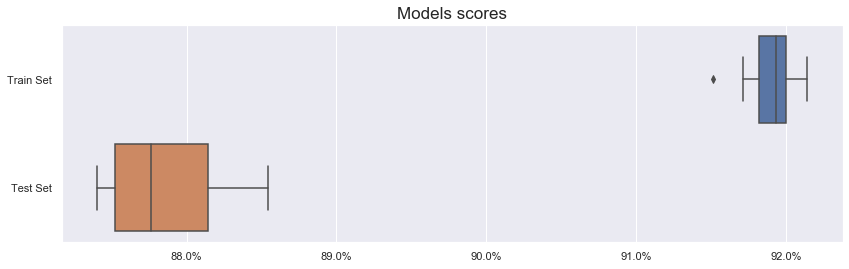

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply seaborn style on matplotlib
sns.set()

import matplotlib.ticker as mtick
import numpy as np

print("Avg score on train sets : {:2.1f}%".format(np.mean(score_train)*100))
print("Avg score on test sets : {:2.1f}%".format(np.mean(score_test)*100))

scores = pd.DataFrame.from_dict({"Train Set" : score_train, "Test Set" : score_test})

plt.figure(figsize=(14, 4))
sns.boxplot(data=scores, orient="h")
plt.title("Models scores", fontsize=17)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
plt.show()

In [12]:
model = LGBMClassifier(**hyp_params, objective = "binary", verbose = -1)
model.fit(X_train, y_train)

print("Score Train :{:5.1f}%".format(f1_score(y_train, model.predict(X_train))*100))
print("Score Test :{:5.1f}%".format(f1_score(y_test, model.predict(X_test))*100))

Score Train : 91.9%
Score Test : 87.5%


In [13]:
from sklearn.metrics import recall_score, precision_score

print("Recall Test :{:5.1f}%".format(recall_score(y_test,model.predict(X_test))*100))
print("Precision Test :{:5.1f}%".format(precision_score(y_test,model.predict(X_test))*100))

Recall Test : 96.2%
Precision Test : 80.2%


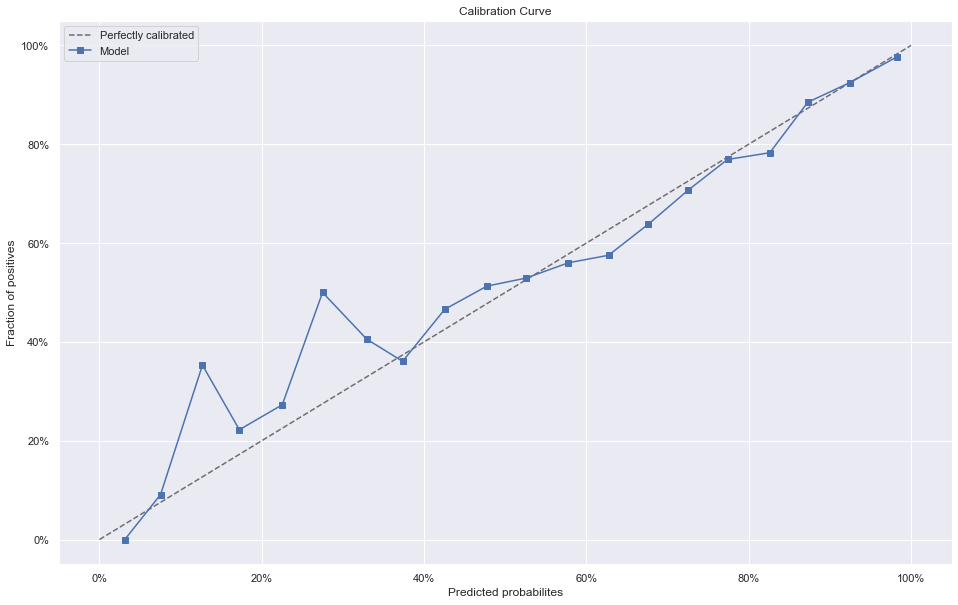

In [17]:
import matplotlib.ticker as mtick

from sklearn.calibration import calibration_curve

prob_pos = model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=20)

plt.figure(figsize=(16, 10))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated", alpha=0.6)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.ylabel("Fraction of positives")
plt.xlabel("Predicted probabilites")
plt.legend()
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.title("Calibration Curve")
plt.show()

In [22]:
fraction_of_positives

array([0.        , 0.09090909, 0.35294118, 0.22222222, 0.27272727,
       0.5       , 0.40540541, 0.36065574, 0.46590909, 0.51282051,
       0.52898551, 0.56      , 0.57525084, 0.63793103, 0.70736086,
       0.76911544, 0.78272605, 0.88494318, 0.92449664, 0.97672163])

In [23]:
mean_predicted_value

array([0.03115264, 0.0752687 , 0.12689695, 0.17238313, 0.22524445,
       0.27488565, 0.32937814, 0.37347299, 0.42544927, 0.47739906,
       0.52533594, 0.57772602, 0.62722267, 0.67610766, 0.72556837,
       0.77384465, 0.82588865, 0.87277916, 0.92441237, 0.98260924])

In [24]:
y_test

19674    1
9842     1
4135     1
6758     1
2829     1
        ..
22602    1
8650     1
7111     1
9207     1
11994    0
Name: purchase, Length: 5743, dtype: int32

In [27]:
prob_pos

array([0.67888192, 0.9108937 , 0.96148197, ..., 0.77127663, 0.81935051,
       0.42891797])